<a href="https://colab.research.google.com/github/JoshuneArriaga/Apendizaje_Automatico/blob/main/Tarea_8_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, mean_absolute_error,
                             mean_squared_error, r2_score, confusion_matrix,
                             classification_report, ConfusionMatrixDisplay)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.stats import zscore, shapiro, skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [101]:
df = pd.read_csv("/content/newborn_health_monitoring_with_risk.csv")
df
risk_level_original = df['risk_level'].copy()

# **Preprocesamiento de datos**

In [102]:
# Imputación de apgar_score por grupo
df['apgar_score'] = df.groupby('baby_id')['apgar_score'].ffill()
df['apgar_score'] = df.groupby('baby_id')['apgar_score'].bfill()

# Eliminar columnas no relevantes
df = df.drop(columns=['baby_id', 'date', 'name'], errors='ignore')

# **Análisis exploratorio y PCA**



In [103]:
print("ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)")

numericas = [
    'gestational_age_weeks', 'birth_weight_kg', 'birth_length_cm',
    'birth_head_circumference_cm', 'age_days', 'weight_kg', 'length_cm',
    'head_circumference_cm', 'temperature_c', 'heart_rate_bpm',
    'respiratory_rate_bpm', 'oxygen_saturation', 'feeding_frequency_per_day',
    'urine_output_count', 'stool_count', 'jaundice_level_mg_dl', 'apgar_score'
]

# Filtrar solo columnas numéricas que existen
numericas = [col for col in numericas if col in df.columns]
X_pca = df[numericas].copy()

# Escalar datos
scaler = StandardScaler()
X_escalada = scaler.fit_transform(X_pca)

# Aplicar PCA
pca = PCA()
pca.fit(X_escalada)

var_explained = pca.explained_variance_ratio_
cumsum_var = np.cumsum(var_explained)
n_components_70 = np.argmax(cumsum_var >= 0.70) + 1

print(f"\nVarianza explicada por componente:")
for i in range(min(5, len(var_explained))):
    print(f"  PC{i+1}: {var_explained[i]*100:.2f}% (acumulado: {cumsum_var[i]*100:.2f}%)")
print(f"\n{n_components_90} componentes explican el 70% de la varianza")

ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)

Varianza explicada por componente:
  PC1: 13.05% (acumulado: 13.05%)
  PC2: 12.68% (acumulado: 25.73%)
  PC3: 10.92% (acumulado: 36.65%)
  PC4: 8.33% (acumulado: 44.98%)
  PC5: 6.43% (acumulado: 51.41%)

9 componentes explican el 70% de la varianza


In [104]:
# Análisis de loadings
loadings_df = pd.DataFrame(
    pca.components_[:5].T,
    columns=[f'PC{i+1}' for i in range(5)],
    index=numericas
)
loadings_df['Importancia_Total'] = loadings_df.abs().sum(axis=1)
loadings_df = loadings_df.sort_values('Importancia_Total', ascending=False)

print(f"\nTop 10 variables más importantes:")
print(loadings_df[['PC1', 'PC2', 'PC3', 'Importancia_Total']].head(10).to_string())

# Seleccionar variables más importantes para clustering
top_variables = loadings_df.head(12).index.tolist()
print(f"\nVariables seleccionadas para clustering: {len(top_variables)}")



Top 10 variables más importantes:
                                  PC1       PC2       PC3  Importancia_Total
birth_weight_kg             -0.204817  0.503854 -0.097997           1.432031
birth_length_cm              0.432596  0.096759  0.511442           1.282477
length_cm                    0.446777  0.175985  0.501300           1.272048
birth_head_circumference_cm  0.504497 -0.033396 -0.455800           1.227548
weight_kg                   -0.137562  0.631287 -0.090942           1.178137
jaundice_level_mg_dl        -0.086167 -0.332096  0.020212           1.160790
head_circumference_cm        0.515106  0.014122 -0.451349           1.145961
age_days                     0.113641  0.415044 -0.002833           1.126690
apgar_score                  0.094305  0.070764 -0.183080           1.083803
gestational_age_weeks       -0.021466  0.124580 -0.144429           1.038405

Variables seleccionadas para clustering: 12


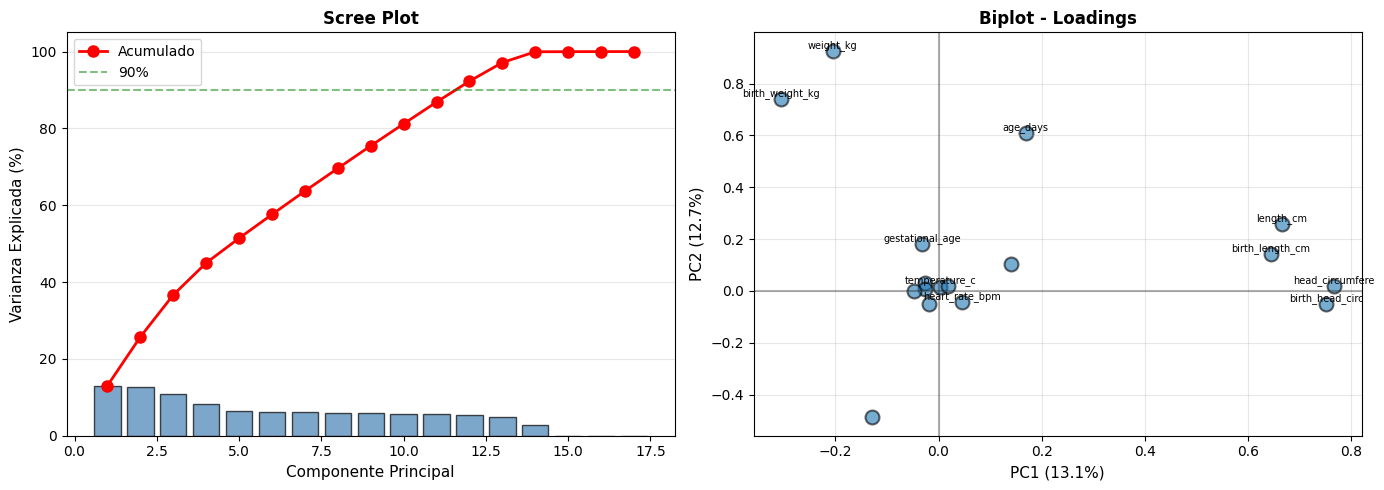

In [105]:

# Visualización PCA
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(1, len(var_explained)+1), var_explained * 100,
            color='steelblue', edgecolor='black', alpha=0.7)
axes[0].plot(range(1, len(var_explained)+1), cumsum_var * 100,
             'ro-', linewidth=2, markersize=8, label='Acumulado')
axes[0].axhline(y=90, color='g', linestyle='--', alpha=0.5, label='90%')
axes[0].set_xlabel('Componente Principal', fontsize=11)
axes[0].set_ylabel('Varianza Explicada (%)', fontsize=11)
axes[0].set_title('Scree Plot', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

loadings = pca.components_[:2].T * np.sqrt(pca.explained_variance_[:2])
axes[1].scatter(loadings[:, 0], loadings[:, 1], s=100, alpha=0.6,
                edgecolors='black', linewidth=1.5)

for i, var in enumerate(numericas[:10]):
    axes[1].annotate(var[:15], (loadings[i, 0], loadings[i, 1]),
                     fontsize=7, ha='center', va='bottom')

axes[1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[1].axvline(x=0, color='k', linestyle='-', alpha=0.3)
axes[1].set_xlabel(f'PC1 ({var_explained[0]*100:.1f}%)', fontsize=11)
axes[1].set_ylabel(f'PC2 ({var_explained[1]*100:.1f}%)', fontsize=11)
axes[1].set_title('Biplot - Loadings', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


# **CLUSTERING DBSCAN**

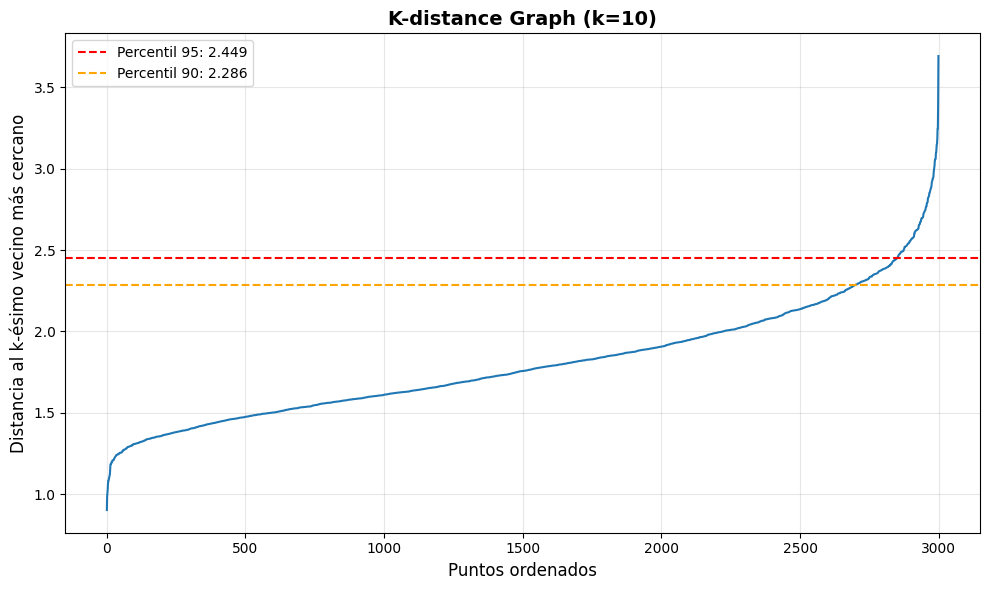


Epsilon sugerido (percentil 95): 2.4491


In [106]:
# Preparar datos para clustering
X_clustering = df[top_variables].copy()
X_clustering_scaled = scaler.fit_transform(X_clustering)

# Determinar epsilon óptimo usando K-distance graph
min_samples = 10
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_clustering_scaled)
distances, indices = neighbors_fit.kneighbors(X_clustering_scaled)

# Ordenar distancias
distances = np.sort(distances[:, -1], axis=0)

# Visualizar K-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.ylabel('Distancia al k-ésimo vecino más cercano', fontsize=12)
plt.xlabel('Puntos ordenados', fontsize=12)
plt.title(f'K-distance Graph (k={min_samples})', fontsize=14, fontweight='bold')
plt.axhline(y=np.percentile(distances, 95), color='r', linestyle='--',
            label=f'Percentil 95: {np.percentile(distances, 95):.3f}')
plt.axhline(y=np.percentile(distances, 90), color='orange', linestyle='--',
            label=f'Percentil 90: {np.percentile(distances, 90):.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('kdistance_graph.png', dpi=300, bbox_inches='tight')
plt.show()

epsilon_suggested = np.percentile(distances, 95)
print(f"\nEpsilon sugerido (percentil 95): {epsilon_suggested:.4f}")

In [107]:
print("\n Factores y Niveles para DBSCAN")
print(f"{'Factor':<25} {'Niveles'}")

print(f"{'eps (epsilon)':<25} {[epsilon_suggested * 0.8, epsilon_suggested, epsilon_suggested * 1.2]}")
print(f"{'min_samples':<25} {[5, 10, 15]}")


# Evaluar diferentes combinaciones de hiperparámetros
epsilon_values = [epsilon_suggested * 0.8, epsilon_suggested, epsilon_suggested * 1.2]
min_samples_values = [5, 10, 15]

resultados_dbscan = []

for eps in epsilon_values:
    for min_samp in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samp, n_jobs=-1)
        labels = dbscan.fit_predict(X_clustering_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        # Calcular métricas solo si hay clusters válidos
        if n_clusters > 1:
            mask = labels != -1
            X_sin_ruido = X_clustering_scaled[mask]
            labels_no_noise = labels[mask]

            silhouette = silhouette_score(X_sin_ruido, labels_no_noise)
            davies = davies_bouldin_score(X_sin_ruido, labels_no_noise)
            calinski = calinski_harabasz_score(X_sin_ruido, labels_no_noise)
        else:
            silhouette = davies = calinski = np.nan

        resultados_dbscan.append({
            'epsilon': eps,
            'min_samples': min_samp,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_pct': (n_noise / len(labels)) * 100,
            'silhouette': silhouette,
            'davies_bouldin': davies,
            'calinski_harabasz': calinski,
            'labels': labels
        })

# Mostrar resultados
df_dbscan_results = pd.DataFrame(resultados_dbscan)
print("\nResultados del Diseño de Experimentos DBSCAN:")
print(df_dbscan_results[['epsilon', 'min_samples', 'n_clusters', 'noise_pct',
                         'silhouette', 'davies_bouldin']].to_string(index=False))



 Factores y Niveles para DBSCAN
Factor                    Niveles
eps (epsilon)             [np.float64(1.9592428888335869), np.float64(2.4490536110419834), np.float64(2.93886433325038)]
min_samples               [5, 10, 15]

Resultados del Diseño de Experimentos DBSCAN:
 epsilon  min_samples  n_clusters  noise_pct  silhouette  davies_bouldin
1.959243            5          11   2.633333   -0.066030        1.173452
1.959243           10           9   7.500000   -0.045798        1.198447
1.959243           15           8  14.800000   -0.062094        1.162537
2.449054            5           2   0.200000    0.192541        1.185408
2.449054           10           2   0.533333    0.186034        1.145973
2.449054           15           2   0.900000    0.180725        1.117107
2.938864            5           1   0.000000         NaN             NaN
2.938864           10           1   0.000000         NaN             NaN
2.938864           15           1   0.000000         NaN             N


Mejor configuración DBSCAN:
  Epsilon: 2.4491
  Min_samples: 5
  Clusters encontrados: 2
  Silhouette Score: 0.1925
  Davies-Bouldin Index: 1.1854 (menor es mejor)
  Ruido: 0.20%


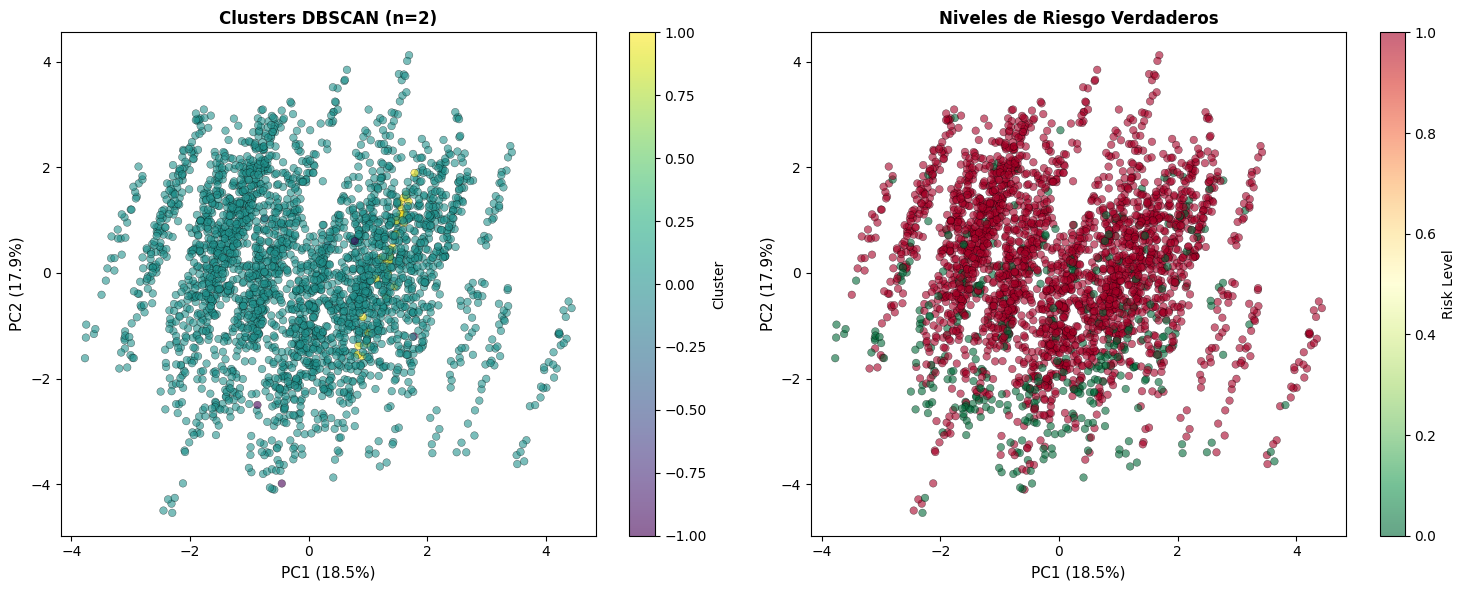


Comparación con etiquetas reales (sin puntos de ruido):
  Adjusted Rand Index: 0.0042
  Normalized Mutual Information: 0.0002


In [108]:
#Seleccionar mejor configuración
df_dbscan_valid = df_dbscan_results[df_dbscan_results['silhouette'].notna()]
if len(df_dbscan_valid) > 0:
    best_idx = df_dbscan_valid['silhouette'].idxmax()
    best_config = df_dbscan_results.loc[best_idx]

    print(f"\nMejor configuración DBSCAN:")
    print(f"  Epsilon: {best_config['epsilon']:.4f}")
    print(f"  Min_samples: {best_config['min_samples']}")
    print(f"  Clusters encontrados: {best_config['n_clusters']}")
    print(f"  Silhouette Score: {best_config['silhouette']:.4f}")
    print(f"  Davies-Bouldin Index: {best_config['davies_bouldin']:.4f} (menor es mejor)")
    print(f"  Ruido: {best_config['noise_pct']:.2f}%")

    # Usar la mejor configuración
    best_labels = best_config['labels']
else:
    print("\nAdvertencia: No se encontraron configuraciones válidas. Usando configuración por defecto.")
    best_labels = resultados_dbscan[0]['labels']
    best_config = resultados_dbscan[0]

# Visualización de clusters
pca_viz = PCA(n_components=2)
X_pca_viz = pca_viz.fit_transform(X_clustering_scaled)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

#Clusters de DBSCAN
scatter1 = axes[0].scatter(X_pca_viz[:, 0], X_pca_viz[:, 1],
                          c=best_labels, cmap='viridis',
                          s=30, alpha=0.6, edgecolors='k', linewidth=0.3)
axes[0].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
axes[0].set_title(f'Clusters DBSCAN (n={best_config["n_clusters"]})', fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

#Niveles de riesgo reales
le = LabelEncoder()
risk_encoded = le.fit_transform(risk_level_original.fillna('unknown'))
scatter2 = axes[1].scatter(X_pca_viz[:, 0], X_pca_viz[:, 1],
                          c=risk_encoded, cmap='RdYlGn_r',
                          s=30, alpha=0.6, edgecolors='k', linewidth=0.3)
axes[1].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
axes[1].set_title('Niveles de Riesgo Verdaderos', fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Risk Level')

plt.tight_layout()
plt.savefig('clustering_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

#Comparar clustering con etiquetas reales
mask_valid = best_labels != -1
if sum(mask_valid) > 0:
    ari = adjusted_rand_score(risk_encoded[mask_valid], best_labels[mask_valid])
    nmi = normalized_mutual_info_score(risk_encoded[mask_valid], best_labels[mask_valid])

    print(f"\nComparación con etiquetas reales (sin puntos de ruido):")
    print(f"  Adjusted Rand Index: {ari:.4f}")
    print(f"  Normalized Mutual Information: {nmi:.4f}")

# **Preparación de datos para clasificación**

In [84]:
# Codificar variables categóricas
df_copy = df.copy()
df = df.drop(columns=['apgar_score'], errors='ignore')
features_cat = ['gender', 'reflexes_normal', 'feeding_type', 'immunizations_done','risk_level']
features_cat = [col for col in features_cat if col in df.columns]

# Crear un encoder por columna
label_encoders = {}

for col in features_cat:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [85]:
df

,gender,gestational_age_weeks,birth_weight_kg,birth_length_cm,birth_head_circumference_cm,age_days,weight_kg,length_cm,head_circumference_cm,temperature_c,...,respiratory_rate_bpm,oxygen_saturation,feeding_type,feeding_frequency_per_day,urine_output_count,stool_count,jaundice_level_mg_dl,immunizations_done,reflexes_normal,risk_level
0,0,40.2,3.30,50.0,31.9,1,3.28,50.1,32.0,37.0,...,36,98,1,11,9,0,4.2,1,1,0
1,0,40.2,3.30,50.0,31.9,2,3.35,50.2,32.0,37.2,...,40,99,1,11,5,2,10.6,0,0,0
2,0,40.2,3.30,50.0,31.9,3,3.35,50.6,32.1,37.1,...,37,97,0,7,6,5,9.8,0,0,1
3,0,40.2,3.30,50.0,31.9,4,3.48,50.3,32.0,37.4,...,33,97,2,11,8,4,8.1,0,1,1
4,0,40.2,3.30,50.0,31.9,5,3.50,50.3,31.8,36.8,...,39,96,0,11,7,1,11.6,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1,39.1,4.47,50.8,36.3,26,5.29,52.4,36.9,36.7,...,44,96,1,8,7,4,4.0,0,1,1
2996,1,39.1,4.47,50.8,36.3,27,5.23,52.1,36.8,37.0,...,31,98,0,7,6,1,2.4,0,1,1
2997,1,39.1,4.47,50.8,36.3,28,5.29,52.3,36.7,36.8,...,42,98,0,8,4,1,3.6,0,1,1
2998,1,39.1,4.47,50.8,36.3,29,5.39,52.4,37.0,37.4,...,52,97,2,10,5,2,2.2,0,0,1


In [86]:
print(label_encoders['risk_level'].classes_)
for i, clase in enumerate(label_encoders['risk_level'].classes_):
    print(f"{i} → {clase}")

['At Risk' 'Healthy']
0 → At Risk
1 → Healthy


# **Detección y tratamiento de outliers**

In [90]:
# Método IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_filtered = df.copy()
df_filtered = df[(df >= Q1 - 1.5 * IQR) & (df <= Q3 + 1.5 * IQR)]
df_filtered

print(f"\nDatos originales: {len(df)}")
print(f"Datos después de filtrar outliers: {len(df_filtered)}")
print(f"Outliers removidos: {len(df) - len(df_filtered)} ({(len(df) - len(df_filtered))/len(df)*100:.2f}%)")



Datos originales: 3000
Datos después de filtrar outliers: 3000
Outliers removidos: 0 (0.00%)


In [91]:
df_filtered = df_filtered.fillna(df.median())

In [92]:
df_filtered

,gender,gestational_age_weeks,birth_weight_kg,birth_length_cm,birth_head_circumference_cm,age_days,weight_kg,length_cm,head_circumference_cm,temperature_c,...,respiratory_rate_bpm,oxygen_saturation,feeding_type,feeding_frequency_per_day,urine_output_count,stool_count,jaundice_level_mg_dl,immunizations_done,reflexes_normal,risk_level
0,0,40.2,3.30,50.0,31.9,1,3.28,50.1,32.0,37.0,...,36.0,98.0,1,11,9,0,4.2,0.0,1.0,1.0
1,0,40.2,3.30,50.0,31.9,2,3.35,50.2,32.0,37.2,...,40.0,99.0,1,11,5,2,3.3,0.0,1.0,1.0
2,0,40.2,3.30,50.0,31.9,3,3.35,50.6,32.1,37.1,...,37.0,97.0,0,7,6,5,3.3,0.0,1.0,1.0
3,0,40.2,3.30,50.0,31.9,4,3.48,50.3,32.0,37.4,...,33.0,97.0,2,11,8,4,3.3,0.0,1.0,1.0
4,0,40.2,3.30,50.0,31.9,5,3.50,50.3,31.8,36.8,...,39.0,96.0,0,11,7,1,3.3,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1,39.1,4.47,50.8,36.3,26,5.29,52.4,36.9,36.7,...,44.0,96.0,1,8,7,4,4.0,0.0,1.0,1.0
2996,1,39.1,4.47,50.8,36.3,27,5.23,52.1,36.8,37.0,...,31.0,98.0,0,7,6,1,2.4,0.0,1.0,1.0
2997,1,39.1,4.47,50.8,36.3,28,5.29,52.3,36.7,36.8,...,42.0,98.0,0,8,4,1,3.6,0.0,1.0,1.0
2998,1,39.1,4.47,50.8,36.3,29,5.39,52.4,37.0,37.4,...,52.0,97.0,2,10,5,2,2.2,0.0,1.0,1.0


In [93]:
df_filtered.loc[df['risk_level'] < 1, 'risk_level'] = 0


In [94]:
# Preparar X y Y
X = df_filtered.drop(columns=['risk_level'], errors='ignore')
y = df_filtered['risk_level']

print(f"\nDistribución de clases:")
print(pd.Series(y).value_counts())
print(f"\nClases codificadas: {y.unique()}")

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTamaño conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño conjunto de prueba: {X_test.shape}")


Distribución de clases:
risk_level
1.0    2602
0.0     398
Name: count, dtype: int64

Clases codificadas: [0. 1.]

Tamaño conjunto de entrenamiento: (2400, 20)
Tamaño conjunto de prueba: (600, 20)


# **Diseño de experimentos - optimización de hiperparámetros**

In [95]:
print("\n Factores y Niveles para Random Forest")
print(f"{'Factor':<25} {'Niveles'}")
print(f"{'n_estimators':<25} {[100, 200, 300]}")
print(f"{'max_depth':<25} {[5, 10, 15, None]}")
print(f"{'min_samples_split':<25} {[2, 5, 10]}")
print(f"{'min_samples_leaf':<25} {[1, 2, 4]}")


# Definir grid de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Generar todas las combinaciones
keys = param_grid.keys()
values = param_grid.values()
combinaciones = [dict(zip(keys, v)) for v in product(*values)]

# Muestrear 20 combinaciones aleatoriamente
np.random.seed(42)
if len(combinaciones) > 20:
    indices_seleccionados = np.random.choice(len(combinaciones), size=20, replace=False)
    combinaciones = [combinaciones[i] for i in indices_seleccionados]

print(f"\nEvaluando {len(combinaciones)} combinaciones de hiperparámetros...")

# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar cada combinación
resultados_rf = []
mejor_score = 0
mejores_params = None

for i, params in enumerate(combinaciones, 1):
    model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)

    # Validación cruzada
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)
    score_mean = scores.mean()
    score_std = scores.std()

    resultados_rf.append({
        'Tratamiento': i,
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'min_samples_split': params['min_samples_split'],
        'min_samples_leaf': params['min_samples_leaf'],
        'F1_CV_Mean': score_mean,
        'F1_CV_Std': score_std
    })

    if score_mean > mejor_score:
        mejor_score = score_mean
        mejores_params = params

    if i % 5 == 0:
        print(f"  Evaluados: {i}/{len(combinaciones)} tratamientos...")

print("\n Top 10 Configuraciones Random Forest (ordenadas por F1-Score CV)")
df_rf_results = pd.DataFrame(resultados_rf).sort_values('F1_CV_Mean', ascending=False)
print(df_rf_results.head(10).to_string(index=False))


print(f"\n Mejor configuración Random Forest:")
print(f"  n_estimators: {mejores_params['n_estimators']}")
print(f"  max_depth: {mejores_params['max_depth']}")
print(f"  min_samples_split: {mejores_params['min_samples_split']}")
print(f"  min_samples_leaf: {mejores_params['min_samples_leaf']}")
print(f"  F1-Score (CV): {mejor_score:.4f}")



 Factores y Niveles para Random Forest
Factor                    Niveles
n_estimators              [100, 200, 300]
max_depth                 [5, 10, 15, None]
min_samples_split         [2, 5, 10]
min_samples_leaf          [1, 2, 4]

Evaluando 20 combinaciones de hiperparámetros...
  Evaluados: 5/20 tratamientos...
  Evaluados: 10/20 tratamientos...
  Evaluados: 15/20 tratamientos...
  Evaluados: 20/20 tratamientos...

 Top 10 Configuraciones Random Forest (ordenadas por F1-Score CV)
 Tratamiento  n_estimators  max_depth  min_samples_split  min_samples_leaf  F1_CV_Mean  F1_CV_Std
          15           100       15.0                  2                 1    0.888969   0.012707
           2           100       10.0                  2                 2    0.888855   0.010833
          16           200        NaN                 10                 1    0.888725   0.009126
          19           300        NaN                 10                 2    0.888385   0.009429
           6         

# **EVALUACIÓN FINAL RANDOM FOREST**

In [96]:

# Entrenar modelo final con mejores parámetros
modelo_final = RandomForestClassifier(**mejores_params, random_state=42, n_jobs=-1)
modelo_final.fit(X_train, y_train)

# Predicciones
y_pred = modelo_final.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Métricas por clase
precision_per_class = precision_score(y_test, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_test, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_test, y_pred, average=None, zero_division=0)

print("\n Métricas de Desempeño - Random Forest Optimizado")

print(f"{'Métrica':<30} {'Valor'}")

print(f"{'Accuracy':<30} {accuracy:.4f}")
print(f"{'Precision (weighted)':<30} {precision:.4f}")
print(f"{'Recall (weighted)':<30} {recall:.4f}")
print(f"{'F1-Score (weighted)':<30} {f1:.4f}")


print("\n Métricas por Clase")

print(f"{'Clase':<20} {'Precision':<15} {'Recall':<15} {'F1-Score'}")

for i, clase in enumerate(y.unique()):
    print(f"{clase:<20} {precision_per_class[i]:<15.4f} {recall_per_class[i]:<15.4f} {f1_per_class[i]:.4f}")


# Reporte de clasificación completo
nombres_clases = {
    0.0: "En Riesgo",
    1.0: "Saludable"
}

print(classification_report(
    y_test,
    y_pred,
    target_names=[nombres_clases[c] for c in sorted(nombres_clases.keys())]
))

# Importancia de características
importancias = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': modelo_final.feature_importances_
}).sort_values(by='Importancia', ascending=False)

print("\nTop 10 Variables Más Importantes")

print(importancias.head(10).to_string(index=False))



 Métricas de Desempeño - Random Forest Optimizado
Métrica                        Valor
Accuracy                       0.9050
Precision (weighted)           0.8954
Recall (weighted)              0.9050
F1-Score (weighted)            0.8941

 Métricas por Clase
Clase                Precision       Recall          F1-Score
0.0                  0.7447          0.4375          0.5512
1.0                  0.9186          0.9769          0.9469
              precision    recall  f1-score   support

   En Riesgo       0.74      0.44      0.55        80
   Saludable       0.92      0.98      0.95       520

    accuracy                           0.91       600
   macro avg       0.83      0.71      0.75       600
weighted avg       0.90      0.91      0.89       600


Top 10 Variables Más Importantes
             Variable  Importancia
             age_days     0.220009
       heart_rate_bpm     0.155620
 jaundice_level_mg_dl     0.091373
            weight_kg     0.069570
            length_cm

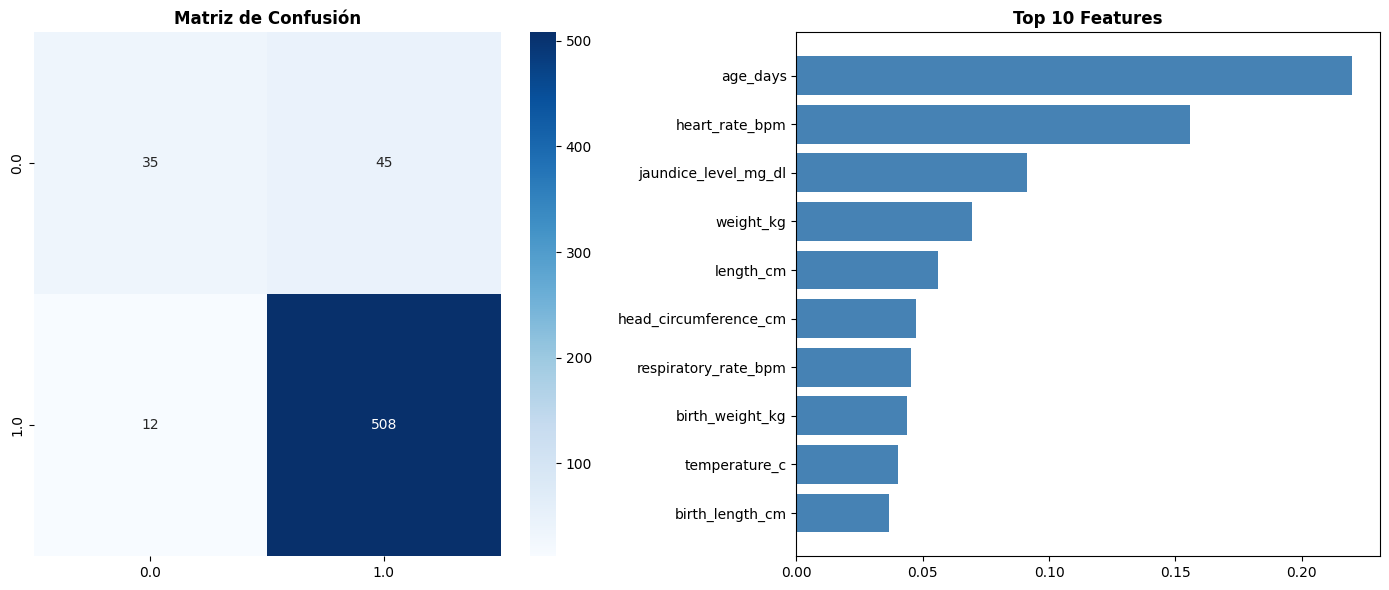

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))

# --- Matriz de Confusión ---
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(c) for c in le_y.classes_],
            yticklabels=[str(c) for c in le_y.classes_],
            ax=axs[0])
axs[0].set_title("Matriz de Confusión", fontweight="bold")

# --- Importancia de Features ---
top_10 = importancias.head(10)
axs[1].barh(top_10['Variable'], top_10['Importancia'], color='steelblue')
axs[1].set_title("Top 10 Features", fontweight="bold")
axs[1].invert_yaxis()

plt.tight_layout()
plt.show()

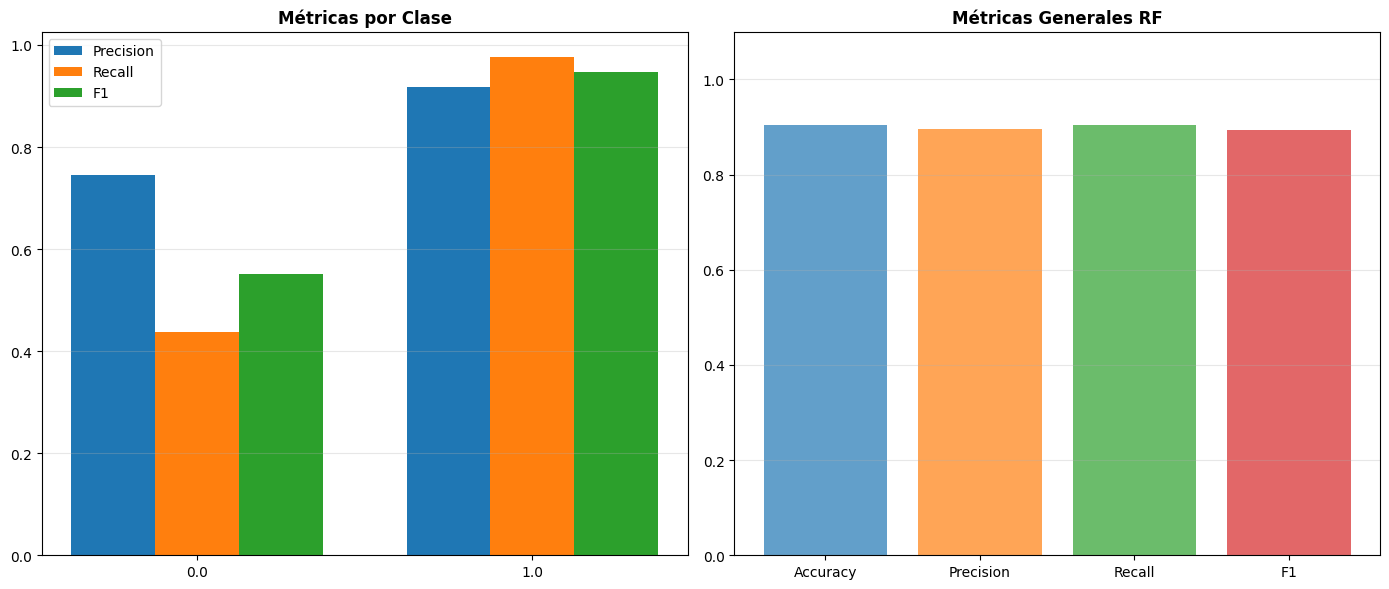

In [98]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))

# --- Métricas por clase ---
x_pos = np.arange(len(le_y.classes_))
width = 0.25
axs[0].bar(x_pos - width, precision_per_class, width, label='Precision')
axs[0].bar(x_pos, recall_per_class, width, label='Recall')
axs[0].bar(x_pos + width, f1_per_class, width, label='F1')
axs[0].set_xticks(x_pos)
axs[0].set_xticklabels([str(c) for c in le_y.classes_])
axs[0].set_title("Métricas por Clase", fontweight="bold")
axs[0].legend()
axs[0].grid(axis='y', alpha=0.3)

# --- Métricas Generales ---
metricas_generales = ['Accuracy', 'Precision', 'Recall', 'F1']
valores_generales = [accuracy, precision, recall, f1]
axs[1].bar(metricas_generales, valores_generales,
           color=['#1f77b4','#ff7f0e','#2ca02c','#d62728'], alpha=0.7)
axs[1].set_ylim(0,1.1)
axs[1].set_title("Métricas Generales RF", fontweight="bold")
axs[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

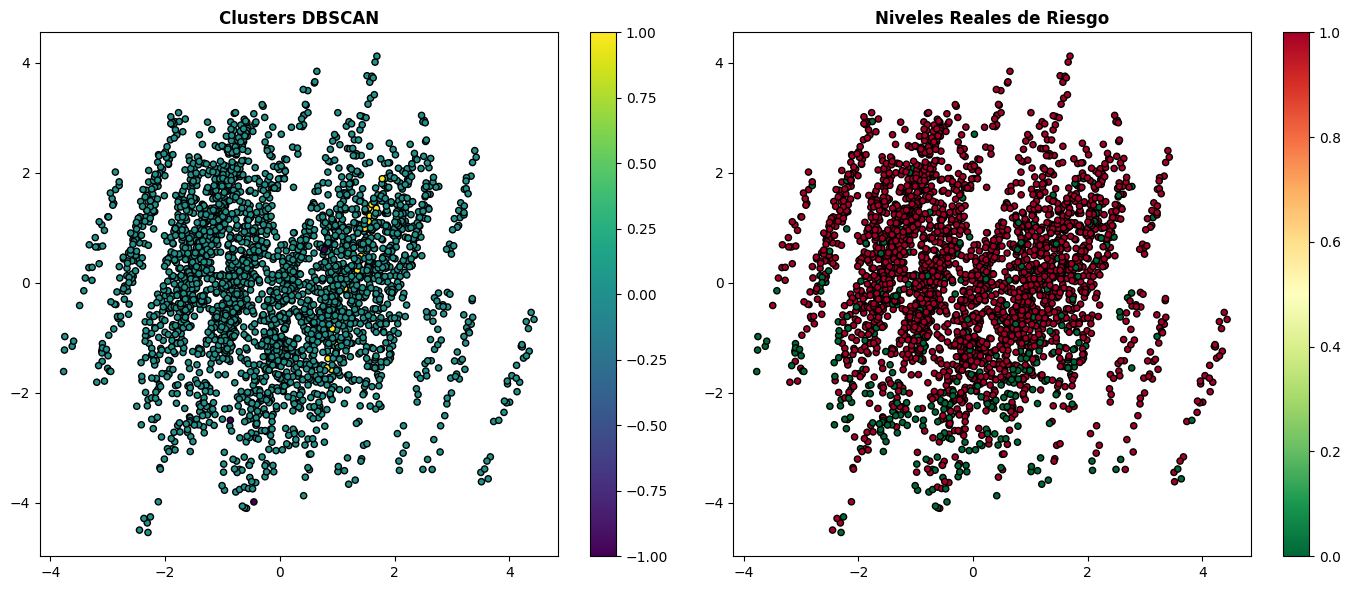

In [99]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))

# --- DBSCAN ---
scatter = axs[0].scatter(X_pca_viz[:, 0], X_pca_viz[:, 1],
                         c=best_labels, cmap='viridis', s=20, edgecolors='k')
axs[0].set_title("Clusters DBSCAN", fontweight="bold")
plt.colorbar(scatter, ax=axs[0])

# --- Riesgo Real ---
scatter2 = axs[1].scatter(X_pca_viz[:, 0], X_pca_viz[:, 1],
                          c=risk_encoded, cmap='RdYlGn_r', s=20, edgecolors='k')
axs[1].set_title("Niveles Reales de Riesgo", fontweight="bold")
plt.colorbar(scatter2, ax=axs[1])

plt.tight_layout()
plt.show()

In [75]:
risk_level_original.unique()

array(['At Risk', 'Healthy'], dtype=object)